In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr
from skimage.morphology import binary_erosion, convex_hull_image, convex_hull_object
from matplotlib.colors import ListedColormap

import math
import time
import random
from matplotlib import cm
from collections import deque

from geopy.distance import lonlat, distance

from Astar_netcdf import AStarPlanner
from rrtstar_netcdf import RRTStar
from rrt_netcdf import RRT
show_animation = False

In [4]:
data = xr.open_dataset('wave2021.nc')
data_stat = xr.open_dataset('MED-MFC_006_017_mask_bathy.nc')
mask = data_stat.variables['mask'][0,:,:]
lats = data.variables['latitude'][:]
lons = data.variables['longitude'][:]
lons_mask = data_stat.variables['longitude'][:]
lats_mask = data_stat.variables['latitude'][:]
times = data.variables['time'][:]
# 2021-07-18, 2021-08-23, 2021-08-24, 2021-09-10, 2021-09-18, 
# 2021-10-11, 2021-10-22, 2021-10-27, 2021-10-31, 2021-11-05, 2021-12-18, 2021-03-07
july18 = data.sel(time='2021-08-23') 
wave = july18.variables['VHM0'][:]
data

<xarray.Dataset>
Dimensions:    (latitude: 47, time: 8760, longitude: 62)
Coordinates:
  * latitude   (latitude) float32 41.35 41.4 41.44 41.48 ... 43.19 43.23 43.27
  * time       (time) datetime64[ns] 2021-01-01 ... 2021-12-31T23:00:00
  * longitude  (longitude) float32 8.958 9.0 9.042 9.083 ... 11.42 11.46 11.5
Data variables:
    VHM0       (time, latitude, longitude) float32 ...
Attributes: (12/15)
    bulletin_type:                   forecast
    institution:                     Hellenic Centre for Marine Research (HCM...
    source:                          MEDWAM3
    credit:                          Copernicus Marine Environment Monitoring...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    producer:                        CMEMS-MED Monitoring and Forecasting Centre
    ...                              ...
    area:                            MED
    bulletin_date:                   2022-01-04 12
    FROM_ORIGINAL_FILE__field_type:  hourly_instantaneous_at_time_field
    title:                           Wave fields (2D) - Hourly Instantaneous
    _CoordSysBuilder:                ucar.nc2.dataset.conv.CF1Convention
    history:                         Data extracted from dataset http://local...

In [4]:
# general basemap of Italy configuration space
mp = Basemap(projection='merc',
             llcrnrlon=6.42,  
             llcrnrlat=40.58, 
             urcrnrlon=15.13, 
             urcrnrlat=45.5488,  
             resolution='f') # f

lon, lat = np.meshgrid(lons, lats)   # 62 x 47
x, y = mp(lon, lat)

x_min, y_min = mp(lons.values[0], lats.values[0]) 
x_max, y_max = mp(lons.values[-1], lats.values[-1])   

In [16]:
l = 24
li = 5   # 0   4(7-5)  4   3   2  -  5   11    0    0    3    6    3   
le = 18  # 15  18    18  17    15  - 17   23   12   12   15   18   15   
cost = np.zeros_like(wave[li:le])
contour_raw_meteo = np.zeros_like(wave[li:le])
contour_raw_land = np.logical_xor(mask,binary_erosion(mask)) 
for i in range(le-li):
    cost[i] = 100 * (np.array(wave[i+li]) > 0.8)
    contour_raw_meteo[i]=np.logical_xor(cost[i],binary_erosion(cost[i]))

<ipython-input-17-b2cd44d5b9f1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))


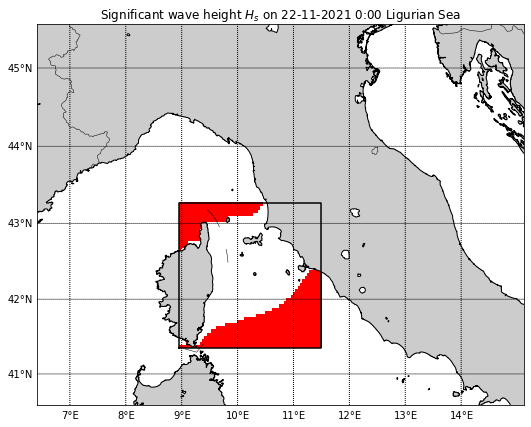

In [17]:
plt.figure(1, figsize=(10, 7))
mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()

In [19]:
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))


In [20]:
xspace = lons.values
yspace = lats.values

sx = xspace[12]  
sy = yspace[7] 
gx = xspace[50]   # [29]  39
gy = yspace[28]   # [37]  33
sx_init, sy_init = mp(sx, sy)
gx_a, gy_a = mp(gx, gy)

# costsum = 0
# for i in range(len(cost)-(k+1)):
#     costsum += cost[i]
# costsum = 100*(np.array(costsum)>=100)

In [21]:
for k in range(4,len(cost)):
    print(k)

4
5
6
7
8
9
10
11
12


In [22]:
oxmeteo, oymeteo = [[] for i in range(le-li)], [[] for i in range(le-li)]     # all meteo points
oxmeteo_, oymeteo_ = [[] for i in range(le-li)], [[] for i in range(le-li)]   # all meteo points
x_obsm, y_obsm = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
x_obsm_, y_obsm_ = [[] for i in range(le-li)], [[] for i in range(le-li)]       # contour meteo points
map_x, map_y = [], []  
map_x_, map_y_ = [], [] 
map_x2, map_y2 = [], []  
map_x_2, map_y_2 = [], [] 
image = np.zeros((47, 62))

for i in range(le-li):
    for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            geo_dist = distance(lonlat(*(lons.values[j],lats.values[k])), lonlat(*(xspace[12],yspace[7]))).km
            if 18*(i) < geo_dist < 18*(i+1):
                costsum = 0
                for r in range(i,len(cost)): # sum all the maps, sum all the maps
                    costsum += cost[r]
                costsum = 100*(np.array(costsum)>=100)
                if costsum[k][j]:
                    image[k][j]=1
                    map_x.append(lons.values[j])
                    map_y.append(lats.values[k]) 
    oxmeteo_[i], oymeteo_[i] = mp(oxmeteo[i], oymeteo[i]) 

astar_contour = np.logical_xor(image,binary_erosion(image)) 
for k in np.arange(0,47,1):
        for j in np.arange(0,62,1):
            if astar_contour[k][j]:
                map_x2.append(lons.values[j])
                map_y2.append(lats.values[k]) 
                
map_x_, map_y_ = mp(map_x, map_y)           # map contour points      
map_x_2, map_y_2 = mp(map_x2, map_y2)       # map contour points     

In [23]:
# sum classico
cost15 = 0
for i in range(len(cost)):
    cost15 += cost[i]
cost15 = 100*(np.array(cost15)>=100)

contour15 = np.logical_xor(cost15,binary_erosion(cost15))

oxmeteo, oymeteo = [], []     # all meteo points
x_obsm, y_obsm = [], []       # contour meteo points
oxmeteo_, oymeteo_ = [], []   # all meteo points
x_obsm_, y_obsm_ = [], []     # contour meteo points


for k in np.arange(0,47,1):
    for j in np.arange(0,62,1):
        if cost15[k][j]:
            oxmeteo.append(lons.values[j])
            oymeteo.append(lats.values[k])
        if contour15[k][j]:
            x_obsm.append(lons.values[j])
            y_obsm.append(lats.values[k])
x_obsm_, y_obsm_ = mp(x_obsm, y_obsm)       # meteo contour points
oxmeteo_, oymeteo_ = mp(oxmeteo, oymeteo)

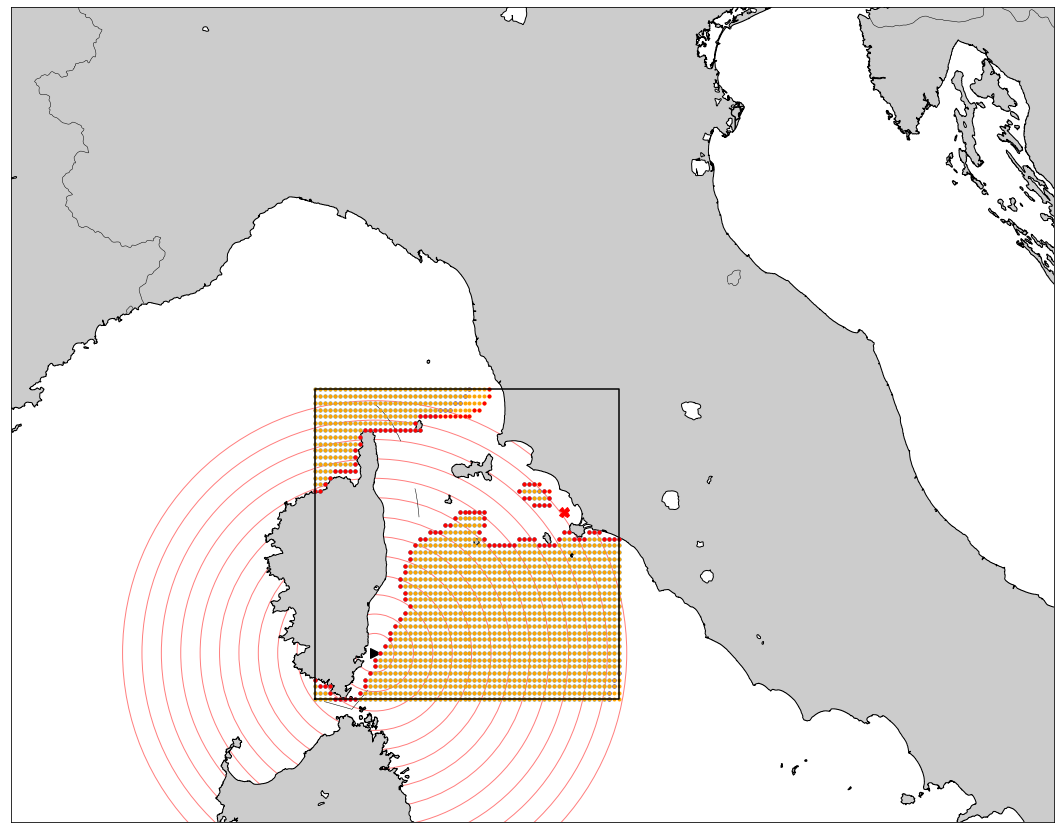

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
mp.plot(sx_init, sy_init, ">k", markersize=10)
plt.plot(gx_a, gy_a, "Xr", markersize=10)




plt.plot(map_x_, map_y_, '.', color="dodgerblue")
plt.plot(map_x_2, map_y_2, '.', color="b")
plt.plot(oxmeteo_, oymeteo_, '.', color="orange")
plt.plot(x_obsm_, y_obsm_, '.', color="red")



# mp.pcolor(x, y, cost[8], cmap=ListedColormap(['white', 'red']))

# mp.pcolor(x, y, cost[1], cmap=ListedColormap(['white', 'red']))
# plt.plot(map_x_2, map_y_2, '.', color="sienna")
for i in range(le-li):
    ax.add_patch(plt.Circle(xy=(sx_init, sy_init), radius=18000*(i+1),
                                color='red', alpha=0.5, fill = False))

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
plt.show()

<ipython-input-26-b2cd44d5b9f1>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))


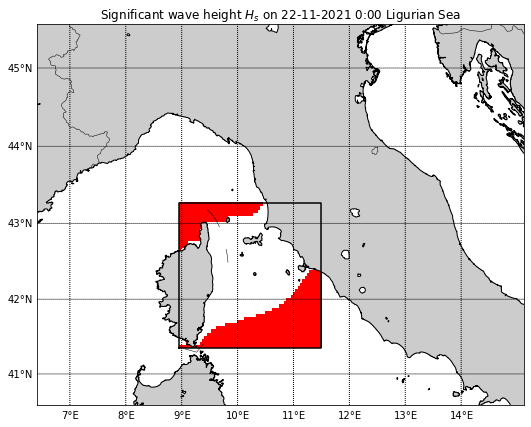

In [26]:
plt.figure(1, figsize=(10, 7))
mp.pcolor(x, y, cost[3], cmap=ListedColormap(['white', 'red']))
mp.fillcontinents()
mp.drawcoastlines()
mp.drawstates()
mp.drawcountries()
mp.drawmeridians(np.arange(6,15,1.0),labels=[0,0,0,1]) #longitudes
mp.drawparallels(np.arange(40,46,1.0),labels=[1,0,0,0]) #latitudes

plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], "-k")
plt.title('Significant wave height $H_s$ on 22-11-2021 0:00 Ligurian Sea')
plt.show()